# Process Dynamics and Control

## Lecture 2: Introduction to frequency domain and Laplace transformation

### Objectives:
* To demonstrate the use of several MATLAB tools;
* To analize the time domain response of systems;
* To get familiar with the frequency domain representation and the Laplace transform;

### Sections:
* Analysis of dynamics:
   * Example 1: First order system
   * Example 2: First order system with delay
   * Example 3: Second order system
* Frequency response of a system:
   * Example 1: Response for a sinusoidal input with frequency $\omega$ = 100
   * Example 2: Response for sinusoidal inputs with different frequencies
* Laplace transform:
   * Example 1: Unit step 
   * Example 2: Exponential function
   * Example 3: Impulse function
   * Singularities in s-plane
   * Partial fraction expansion
   * Inverse Laplace transform

In [1]:
# library imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual, FloatSlider, fixed
import sympy as sp
%matplotlib inline

## Analysis of dynamics: 
Typical responses of a linear process to a step change in the input

<img src="figures/LinearProcess.jpg" alt="figure" style="width: 500px;"/>
<img src="figures/stepchangeinheatinput.jpg" alt="figure" style="width: 469px;"/>


#### **Example 1:** First order system $\hspace{10mm}\tau\frac{dy}{dt}+y = Ku; \hspace{10mm} y(0) = y_0$

In [2]:
def get_analytical_solution(tau, K, y0, u):
    # define symbolic variables
    t = sp.symbols('t')
    Y = sp.Function('Y')(t)
    # first order system
    ode = sp.Eq(tau * Y.diff(t) + Y, K * u)
    sol_analytical = sp.dsolve(ode, Y, ics={Y.subs(t, 0): y0})
    print(f"Analytical solution: {sp.simplify(sol_analytical)}")
    return sp.lambdify(t, sol_analytical.rhs, 'numpy')

In [3]:
def get_numerical_solution(tau, K, y0, u):
    def ode_system(t, y):
        return [(K * u - y[0]) / tau]
    # define time 
    t_span = [0, 20]
    t_values = np.linspace(t_span[0], t_span[1], 400)
    return solve_ivp(ode_system, t_span, [y0], t_eval=t_values, method='DOP853', atol=1e-8, rtol=1e-6)

In [4]:
def solve_and_plot(tau=1.3, K=7, y0=0, u=2):
    # call the previously defined functions for the analytical and numerical solution
    Ysol_a = get_analytical_solution(tau, K, y0, u)
    sol_numeric = get_numerical_solution(tau, K, y0, u)

    t_values = np.linspace(0, 20, 400)  # Time values for plotting
    
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, Ysol_a(t_values), 'b', label='Analytical Solution', linewidth=2)
    plt.plot(sol_numeric.t, sol_numeric.y[0], 'r--', label='Numerical Solution', linewidth=2)
    plt.xlim([t_values[0], t_values[-1]])
    plt.ylim([min(Ysol_a(t_values)), 1.2 * max(Ysol_a(t_values))])
    plt.xlabel('Time'), plt.ylabel('Y')
    plt.title('Comparison of Analytical and Numerical Solutions')
    plt.legend()
    plt.grid(True)
    plt.show();

In [5]:
# Create interactive sliders for ODE parameters
interact(solve_and_plot, 
         tau=FloatSlider(value=1.3, min=0, max=2.0, step=0.1, description='tau'),
         K=FloatSlider(value=7, min=1, max=10, step=1, description='K'),
         y0=FloatSlider(value=0, min=0, max=5, step=1, description='y0'),
         u=FloatSlider(value=2, min=0.1, max=2, step=0.5, description='u'));

interactive(children=(FloatSlider(value=1.3, description='tau', max=2.0), FloatSlider(value=7.0, description='…

#### **Example 2:** First order system with delay $\hspace{10mm}\tau\frac{dy}{dt}+y = Ku(t-\theta); \hspace{10mm} y(0) = y_0$

In [6]:
def get_analytical_solution_with_delay_ex2(tau, K, y0, u, theta):
    t = sp.symbols('t')
    Y = sp.Function('Y')(t)

    # Incorporating delay using the Heaviside function
    ode = sp.Eq(tau * Y.diff(t) + Y, K * u * sp.Heaviside(t - theta))

    sol_analytical = sp.dsolve(ode, Y, ics={Y.subs(t, 0): y0})  
    print(f"Analytical solution: {sp.simplify(sol_analytical)}")
    return sp.lambdify(t, sol_analytical.rhs, 'numpy')

In [7]:
def solve_and_plot_with_delay_ex2(tau=1.3, K=7, y0=0, u=2, theta=1):
    Ysol_a = get_analytical_solution_with_delay_ex2(tau, K, y0, u, theta)
    
    t_values = np.linspace(0, 20, 400)  # Time values for plotting
    y_values = Ysol_a(t_values)

    plt.figure(figsize=(10, 6))
    plt.plot(t_values, y_values, label='Analytical Solution', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Y')
    plt.title('Solution of the ODE with Delay')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
interact(solve_and_plot_with_delay_ex2, 
         tau=FloatSlider(value=1.3, min=0, max=2.0, step=0.1, description='tau'),
         K=FloatSlider(value=7, min=1, max=10, step=1, description='K'),
         y0=FloatSlider(value=0, min=0, max=5, step=1, description='y0'),
         u=FloatSlider(value=2, min=0, max=5, step=0.5, description='u'),
         theta=FloatSlider(value=3, min=0, max=3, step=0.5, description='theta'));

interactive(children=(FloatSlider(value=1.3, description='tau', max=2.0), FloatSlider(value=7.0, description='…

#### **Example 3:** Second order system $\hspace{10mm}\tau^2\frac{d^2y}{dt^2}+2\xi\tau\frac{dy}{dt}+y = Ku; \hspace{10mm}y(0) = y_0   ;  \hspace{10mm}\frac{dy}{dt}(t=0) = f_0$

In [9]:
def get_numerical_solution_ex3(tau=1.3, xi=0.5, K=7, y0=0, f0=0, u=2):
    # Define the ODE system
    def ode_system(t, y, tau, xi, K, u):
        dy, v = y  # y[0] is y, y[1] is dy/dt
        dydt = v
        dvdt = (K * u - 2 * xi * tau * v - dy) / tau**2
        return [dydt, dvdt]

    # Solve the ODE numerically
    t_span = [0, 20]
    t_values = np.linspace(t_span[0], t_span[1], 400)
    y_init = [y0, f0]  # Initial values for y and dy/dt
    sol = solve_ivp(ode_system, t_span, y_init, args=(tau, xi, K, u), t_eval=t_values)
    return sol

In [10]:
def solve_and_plot_ex3(tau=1.3, xi=0.1, K=7, y0=0, f0=0, u=2):
    sol_numeric = get_numerical_solution_ex3(tau, xi, K, y0, f0, u)
    
    # Plotting the solution
    plt.figure(figsize=(10, 6))
    plt.plot(sol_numeric.t, sol_numeric.y[0], label='Numerical Solution', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('y(t)')
    plt.title('Numerical Solution of Second Order ODE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
interact(solve_and_plot_ex3, 
         tau=FloatSlider(value=1.4, min=0.1, max=2.0, step=0.1, description='tau'),
         xi=FloatSlider(value=0.1, min=0, max=2, step=0.1, description='xi'),
         K=FloatSlider(value=1, min=1, max=10, step=1, description='K'),
         y0=fixed(0),
         f0=fixed(0),
         u=FloatSlider(value=1.5, min=0, max=2, step=0.5, description='u'));

interactive(children=(FloatSlider(value=1.4, description='tau', max=2.0, min=0.1), FloatSlider(value=0.1, desc…

## Frequency response of a system:
System response to a sinusoidal input signal for different frequencies:
#### Second order system: $\tau^2\frac{d^2y}{dt^2}+2\xi\tau\frac{dy}{dt}+y = Ku; \hspace{10mm}y(0) = y_0 ; \hspace{10mm}\frac{dy}{dt}(t=0) = f_0$

In [12]:
# System parameters
tau = 0.1
xi = 0.1

# Input parameters
A = 1.0
ph1 = sp.pi / 8
omega = sp.symbols('omega')
t = sp.symbols('t', real=True)
y = sp.Function('y')(t)

In [13]:
# Define the ODE
ode2 = sp.Eq(tau**2 * y.diff(t, t) + 2 * xi * tau * y.diff(t) + y, A * sp.sin(omega * t + ph1))

# Define initial conditions
y0 = 0  # Initial condition for y
f0 = 0  # Initial condition for dy/dt
cond = {y.subs(t, 0): y0, y.diff(t).subs(t, 0): f0}


Gain for omega = 100: 0.010098924139589056


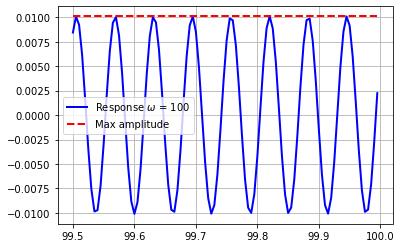

In [14]:
# Solve the ODE
ySol = sp.dsolve(ode2, y, ics=cond)

# Convert to numerical function
Ysol = sp.lambdify((omega, t), ySol.rhs, 'numpy')

# Example 1: omega = 100
omega_val = 100
t_values = np.arange(0, 100, 0.005)
sol_an = Ysol(omega_val, t_values)
M = np.max(sol_an[-100:])

# Gain for omega = 100
gain = M / A
print(f"Gain for omega = 100: {gain}")

# Plotting
plt.plot(t_values[-100:], sol_an[-100:], 'b', linewidth=2)
plt.plot(t_values[-100:], M * np.ones(100), 'r--', linewidth=2)
plt.legend(['Response $\\omega$ = 100', 'Max amplitude'])
plt.grid()
plt.show()

#### **Example 2:** Analysis for different frequencies

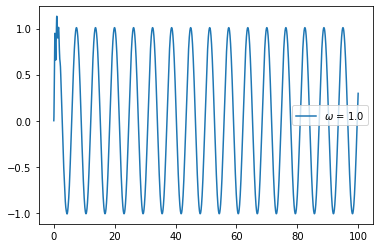

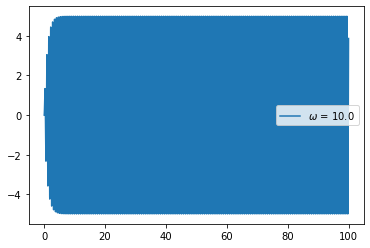

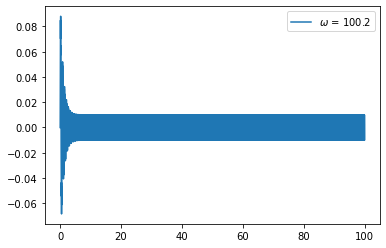

In [15]:
# Example 2: Analysis for different frequencies
w = np.logspace(0, 4, 2000)
gain_w = np.zeros(2000)
indices = [1, 500, 1000, 2000]

# loop over defined frequencies
for i, omega_val in enumerate(w):
    sol_an = Ysol(omega_val, t_values)
    M = np.max(sol_an[-1000:])
    gain_w[i] = abs(M / A)

    if i in indices:
        plt.figure(figsize=(6, 4))
        plt.plot(t_values, sol_an)
        plt.legend([f'$\\omega$ = {omega_val:.1f}'])
        plt.show()

The system behaves differently depending on the frequency of the sinusoidal input. This analysis not only helps to characterize the system behavior, but is also useful in the design of effective control actions, as you will learn in this course! 
The gains calculated in the for loop can be easily summarized and visualized by using the following graph:

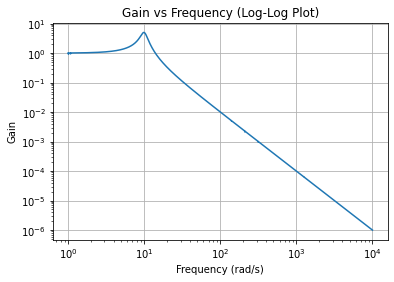

In [16]:
# Plot gain versus frequency on a log-log scale
plt.figure()
plt.loglog(w, gain_w)
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Gain')
plt.title('Gain vs Frequency (Log-Log Plot)')
plt.grid(True)
plt.show()

However, you will learn how to obtain the same information more efficiently using the Laplace transform and Bode plots!

In [17]:
import control as ctl

# Define the transfer function G
s = ctl.TransferFunction.s
K=1
G = K / (tau**2 * s**2 + 2 * xi * tau * s + 1)

# Bode magnitude plot
mag, phase, omega = ctl.bode(G, np.logspace(0, 4, 1000), dB=True, Hz=False, deg=True, plot=False)

# Customizing the plot
plt.figure()
plt.semilogx(omega, 20*np.log10(mag))  # 20*log10(mag) to convert to dB
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Magnitude (dB)')
plt.title('Bode Magnitude Plot')
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'control'

## Laplace transform 
<img src="figures/laplacetransform.jpg" alt="figure" style="width: 500px;"/>


<img src="figures/complexfrequency.jpg" alt="figure" style="width: 500px;"/>


<img src="figures/complexvector.jpg" alt="figure" style="width: 300px;"/>


Complex plane representation:

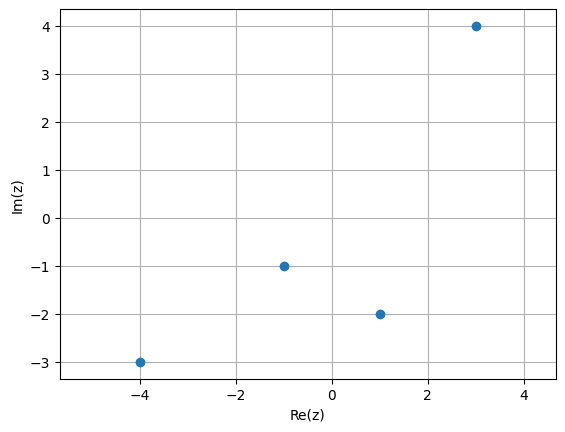

In [ ]:
# Define the complex numbers
z = [3 + 4j, -4 - 3j, 1 - 2j, -1 - 1j]

# Extract real and imaginary parts
real_parts = [num.real for num in z]
imag_parts = [num.imag for num in z]

# Plot
plt.plot(real_parts, imag_parts, "o")
plt.axis('equal')
plt.grid(True)
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.show()

#### **Example 1:** Unit step

<img src="figures/unitsteplaplace.jpg" alt="figure" style="width: 800px;"/>

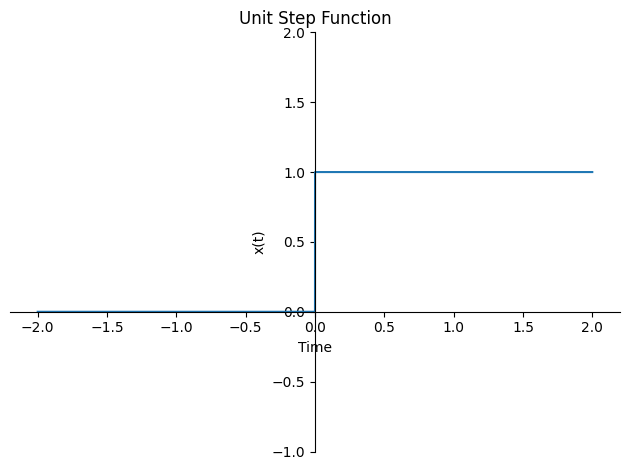

In [ ]:
# Define symbolic variables
t, s = sp.symbols('t s')

# Define unit step
x = sp.Heaviside(t)

# Plot input
sp.plot(x, (t, -2, 2), ylim=(-1, 2), xlabel='Time', ylabel='x(t)', title='Unit Step Function');

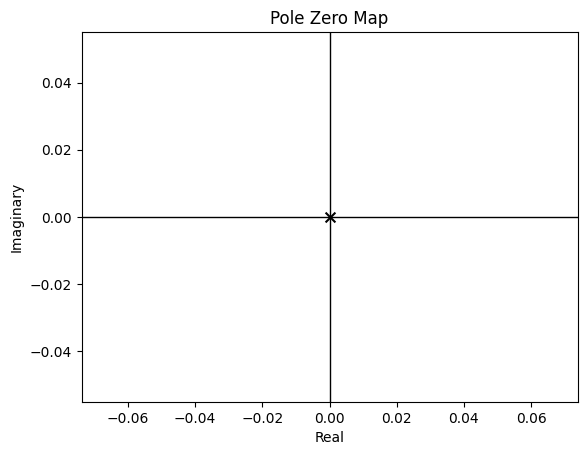

In [ ]:
# Laplace transform
X, _, _ = sp.laplace_transform(x, t, s)

# Get num and den of Symbolic TF
symNum, symDen = sp.fraction(X)

# Convert symbolic num to polynomial
TFnum = sp.Poly(symNum, s).all_coeffs()
TFden = sp.Poly(symDen, s).all_coeffs()

# Define transfer function with control library
X_tf = ctl.TransferFunction(np.array(TFnum, dtype=float), np.array(TFden, dtype=float))

# Plot pole-zero map
plt.figure()
ctl.pzmap(X_tf, plot=True)
plt.xlim([-5, 5])
plt.show()


#### **Example 2:** Exponential function


<img src="figures/exponentiallaplace.jpg" alt="figure" style="width: 800px;"/>


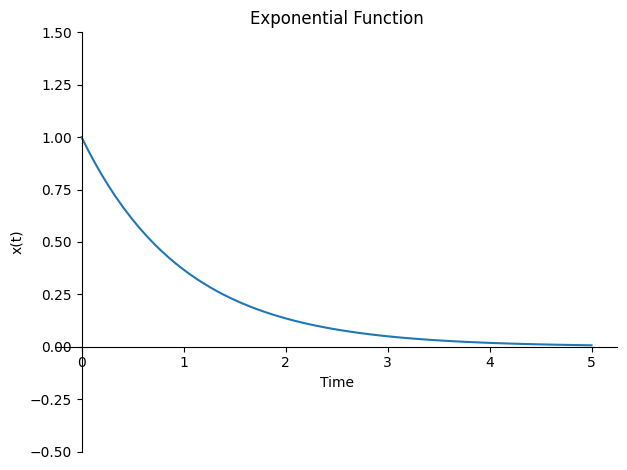

In [ ]:
# Define symbolic variables
t, s = sp.symbols('t s')
a = 1

# Define function
x = sp.exp(-a * t)

# Plot input
p = sp.plot(x, (t, 0, 5), ylim=(-0.5, 1.5), xlabel='Time', ylabel='x(t)', title='Exponential Function', show=False)
p.show()

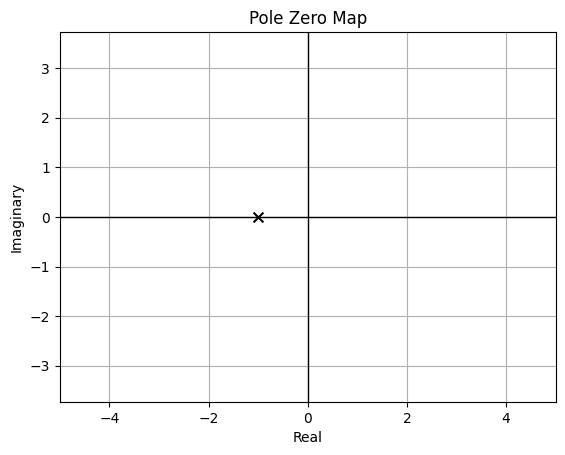

In [ ]:
# Laplace transform
X = sp.laplace_transform(x, t, s, noconds=True)

# Get num and den of Symbolic TF
symNum, symDen = sp.fraction(X)

# Convert symbolic num to polynomial
TFnum = sp.Poly(symNum, s).all_coeffs()
TFden = sp.Poly(symDen, s).all_coeffs()

# Define transfer function with control library
X_tf = ctl.TransferFunction([float(n) for n in TFnum], [float(d) for d in TFden])

# Plot pole-zero map
plt.figure()
ctl.pzmap(X_tf, plot=True)
plt.xlim([-5, 5])
plt.grid()
plt.show()

#### **Example 3:** Impulse (dirac) function

<img src="figures/dirac.jpg" alt="figure" style="width: 400px;"/>

<img src="figures/diraclaplace.jpg" alt="figure" style="width: 290px;"/>

<img src="figures/diraclimit.jpg" alt="figure" style="width: 450px;"/>

In [ ]:
def dirac_slider(t0=0.7):
    t = sp.symbols('t')
    s = sp.symbols('s')

    # Define function
    x = 1/t0 * (sp.Heaviside(t) - sp.Heaviside(t - t0))

    # Plot input
    p = sp.plot(x, (t, -1, 5), ylim=(-1, 10), xlabel='Time', ylabel='x(t)', title='Impulse Function', show=False)
    # p.legend(['Impulse function'])
    p.show()

    # Laplace transform
    X = sp.laplace_transform(x, t, s, noconds=True)

    # Print the Laplace Transform
    print("Laplace Transform:")
    sp.pprint(X)

# Create interactive slider for t0
interact(dirac_slider, t0=FloatSlider(value=0.7, min=0.1, max=2, step=0.1, description='t0'));

interactive(children=(FloatSlider(value=0.7, description='t0', max=2.0, min=0.1), Output()), _dom_classes=('wi…

#### **Singularities in s-plane**
#### Example 1: First order system


In [ ]:
def plot_singularities_ex1(a=1.8):
    # Define the transfer function
    s = ctl.TransferFunction.s
    G_1 = 1 / (s + a)

    # Pole-zero map
    plt.figure()
    ctl.pzmap(G_1, plot=True)
    plt.xlim([-5, 5])
    plt.title('Pole-Zero Map')

    # Time-domain simulation
    t = np.linspace(0, 10, 1000)
    u_step = np.ones_like(t)

    # Simulate response
    t_out, y_out = ctl.forced_response(G_1, T=t, U=u_step)

    # Plotting the response
    plt.figure()
    plt.plot(t_out, y_out)
    plt.xlabel('Time (s)')
    plt.ylabel('Response')
    plt.title('Step Response')
    plt.grid(True)
    plt.show()
interact(plot_singularities_ex1, a=FloatSlider(value=1.8, min=-5, max=5, step=0.2, description='a'));

interactive(children=(FloatSlider(value=1.8, description='a', max=5.0, min=-5.0, step=0.2), Output()), _dom_cl…

#### Example 2: Second order system

In [ ]:
def plot_singularities_ex2(sigma=0.1, omega=7.8):
    s = ctl.TransferFunction.s
    G_2 = (s + sigma) / ((s + sigma)**2 + omega**2)

    # Pole-zero map
    plt.figure()
    ctl.pzmap(G_2, plot=True)
    plt.xlim([-6, 6])
    plt.ylim([-11, 11])
    plt.title('Pole-Zero Map')

    # Time-domain simulation
    t = np.linspace(0, 5, 500) 
    u_step = np.ones_like(t)

    # Simulate response
    t_out, y_out = ctl.forced_response(G_2, T=t, U=u_step)

    # Plotting the response
    plt.figure()
    plt.plot(t_out, y_out)
    plt.xlabel('Time (s)')
    plt.ylabel('Response')
    plt.title('Step Response')
    plt.ylim([-0.5, 0.5])
    plt.grid(True)
    plt.show()


interact(plot_singularities_ex2, 
         sigma=FloatSlider(value=0.1, min=-5, max=5, step=0.1, description='sigma'),
         omega=FloatSlider(value=7.8, min=0, max=10, step=0.1, description='omega'));

interactive(children=(FloatSlider(value=0.1, description='sigma', max=5.0, min=-5.0), FloatSlider(value=7.8, d…

#### **Partial fraction expansion:**

<img src="figures/partialfractionexpansion.jpg" alt="figure" style="width: 800px;"/>

In [ ]:
# Define symbolic variable
s = sp.symbols('s')

# Define F
F = (s + 3) / (s**3 + 3*s**2 + 2*s)

# Define G
G = 1 / (s**2 + 3*s + 2)

# Display F and G
# print("F(s) =", F)
# print("G(s) =", G)

# Enable pretty-printing in Jupyter # TODO: Check if this is needed and wanted
sp.init_printing(use_latex='mathjax')
sp.pretty_print(F)
sp.pretty_print(G)
# F, G

     s + 3     
───────────────
 3      2      
s  + 3⋅s  + 2⋅s
     1      
────────────
 2          
s  + 3⋅s + 2


#### Example 1:  Partial fraction expansion using sp.apart()


In [ ]:
# Partial fraction decomposition
F_p = sp.apart(F, s)
G_p = sp.apart(G, s)

# Display the partial fractions
print("Partial fraction decomposition of F:")
sp.pprint(F_p)

print("\nPartial fraction decomposition of G:")
sp.pprint(G_p)

Partial fraction decomposition of F:
    1         2      3 
───────── - ───── + ───
2⋅(s + 2)   s + 1   2⋅s

Partial fraction decomposition of G:
    1       1  
- ───── + ─────
  s + 2   s + 1


#### Example 2: Partial fraction expansion using residue()

<img src="figures/partialfractionexpansionex2.jpg" alt="figure" style="width: 800px;"/>


In [ ]:
from scipy.signal import residue

# Define numerator and denominator of F
n = [1, 3]
d = [1, 3, 2, 0]

# Determine the partial fraction decomposition
r, p, k = residue(n, d)
print("r", r)
print("p", p)
print("k", k)

# Define the transfer function terms using the Control Systems Library
s = ctl.TransferFunction.s

F_1 = r[0] / (s - p[0])
F_2 = r[1] / (s - p[1])
F_3 = r[2] / (s - p[2])

# Display the terms
print("F_1:", F_1)
print("F_2:", F_2)
print("F_3:", F_3)

r [ 1.5 -2.   0.5]
p [ 0. -1. -2.]
k []
F_1: 
1.5
---
 s

F_2: 
 -2
-----
s + 1

F_3: 
 0.5
-----
s + 2



#### **Inverse Laplace transform:**

<img src="figures/inverselaplace.jpg" alt="figure" style="width: 800px;"/>

<img src="figures/inverselaplacefraction.jpg" alt="figure" style="width: 700px;"/>

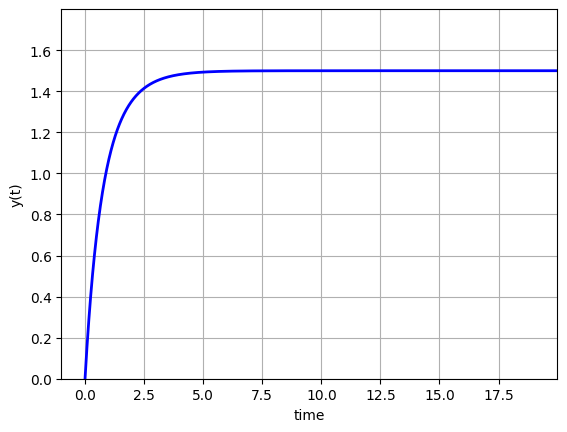

In [ ]:
# Define symbolic variables
s, t = sp.symbols('s t')

# Define F and G
F = (s + 3) / (s**3 + 3*s**2 + 2*s)
G = 1 / (s**2 + 3*s + 2)

# Perform inverse Laplace transform
yf = sp.inverse_laplace_transform(F, s, t)
yg = sp.inverse_laplace_transform(G, s, t)

# Solution using inverse Laplace transform
y = yf + yg

# Convert to a numerical function (lambdify)
y_td = sp.lambdify(t, y)

# Define time vector
dt = 0.01
t0 = 0   # Define start time
te = 20   # Define end time
t_values = np.arange(t0, te, dt)

# Evaluate solution
y_td_values = y_td(t_values)

# Plot solution
plt.plot(t_values, y_td_values, 'b', linewidth=2)
plt.xlim([-1, t_values[-1]])
plt.ylim([min(y_td_values), 1.2 * max(y_td_values)])
plt.xlabel('time')
plt.ylabel('y(t)')
plt.grid(True)
plt.show()

(array([-2.+3.j, -2.-3.j]), array([3.+0.j]))

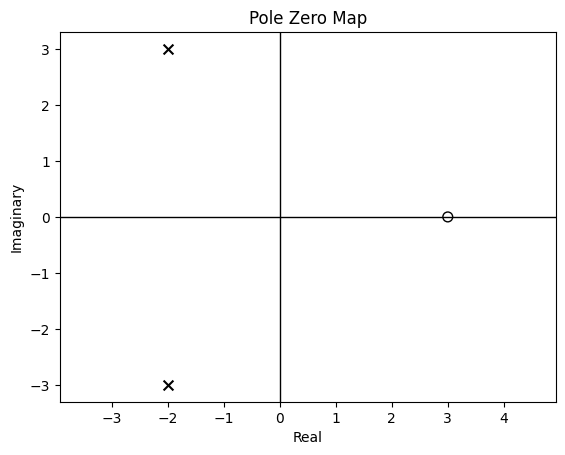

In [ ]:
s = ctl.TransferFunction.s
G_exam = (s-3)/((s**2 + 4*s + 13));

    # Pole-zero map
plt.figure()
ctl.pzmap(G_exam, plot=True)